In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import cv2
import random
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [3]:
BATCH_SIZE = 128

seed = 666
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(666)

In [4]:
import os
os.chdir("/content/drive/My Drive/content")
!ls

flowers  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [5]:
import os
print(os.listdir('/content/drive/My Drive/content/flowers'))

['daisy', 'sunflower', 'rose', 'tulip', 'dandelion']


In [6]:
BATCH_SIZE = 128

seed = 666
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(666)
path_df = pd.DataFrame(columns = ["img_path", "label"])

for flower_type in os.listdir("/content/drive/My Drive/content/flowers"):
    
    temp = pd.DataFrame(columns = ["img_path", "label"])
    img_path = glob.glob(f"/content/drive/My Drive/content/flowers/{flower_type}/*.jpg")   
    temp["img_path"] = img_path
    temp["label"] = flower_type
    
    path_df = pd.concat([path_df, temp])
    
path_df.reset_index(drop = True, inplace = True)

In [7]:
train_data, test_data = train_test_split(path_df, 
                                         test_size = 0.1, 
                                         stratify = path_df["label"], 
                                         random_state = seed, 
                                         shuffle = True)

train_data, val_data = train_test_split(train_data, 
                                        test_size = 0.12, 
                                        stratify = train_data["label"], 
                                        random_state = seed, 
                                        shuffle = True)

print(f"Training set ratio: {len(train_data)/ len(path_df)}")
print(f"Validation set ratio: {len(val_data)/ len(path_df)}")
print(f"Test set ratio: {len(test_data)/ len(path_df)}")

Training set ratio: 0.7917535325457493
Validation set ratio: 0.10817697475098448
Test set ratio: 0.10006949270326616


**Implementation on Keras (Functional API)**

In [8]:
INPUT_SHAPE = (227, 227, 3)
NUM_CLASSES = 5

In [9]:
def AlexNet_func(input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    
    kernel_init = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01, seed = seed)
    
    
    inputs = Input(shape = input_shape)
    
    conv1 = Conv2D(filters = 96, kernel_size = (11, 11), strides = 4, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "zeros", name = "conv1")(inputs)
    conv1 = Lambda(tf.nn.local_response_normalization)(conv1)
    conv1 = MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid")(conv1)
    
    
    conv2 = Conv2D(filters = 256, kernel_size = (5, 5), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "conv2")(conv1)
    conv2 = Lambda(tf.nn.local_response_normalization)(conv2)
    conv2 = MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid")(conv2)
    
    
    conv3 = Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "zeros", name = "conv3")(conv2)
    conv4 = Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones",name = "conv4")(conv3)
    conv5 = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "conv5")(conv4)
    conv5 = MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid")(conv5)
    
    
    dense1 = Flatten()(conv5)
    dense1 = Dense(units = 4096, kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "fc6")(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(units = 4096, kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "fc7")(dense1)
    dense2 = Dropout(0.5)(dense2)    

    dense3 = Dense(units = num_classes, kernel_initializer = kernel_init, 
                   bias_initializer = "ones", activation = "softmax", name = "fc8")(dense2)
    
    
    model = Model(inputs = inputs, outputs = dense3)
    
    return model

In [10]:
optimizer = SGD(learning_rate = 0.01, momentum = 0.9, decay = 0.0005)

In [11]:
tf.keras.backend.clear_session()

model = AlexNet_func(num_classes = 1000)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 57, 57, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 57, 57, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 28, 28, 256)       0         
                                                             

**Implementation on Keras (Sequential)**

In [12]:
def AlexNet(input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    
    kernel_init = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01, seed = seed)
    
    model = Sequential(
        [
            Conv2D(filters = 96, kernel_size = (11, 11), strides = 4, padding = "same", 
                   activation = "relu",  kernel_initializer = kernel_init, 
                   bias_initializer = "zeros", input_shape = input_shape, name = "conv1"),
            Lambda(tf.nn.local_response_normalization),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Conv2D(filters = 256, kernel_size = (5, 5), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "conv2"),
            Lambda(tf.nn.local_response_normalization),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "zeros", name = "conv3"),
            Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones",name = "conv4"),
            Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   bias_initializer = "ones", name = "conv5"),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Flatten(),
            Dense(units = 4096, kernel_initializer = kernel_init, 
                  bias_initializer = "ones", name = "fc6"),
            Dropout(0.5),
            Dense(units = 4096, kernel_initializer = kernel_init, 
                  bias_initializer = "ones", name = "fc7"),
            Dropout(0.5),
            Dense(units = num_classes, kernel_initializer = kernel_init, 
                  bias_initializer = "ones", activation = "softmax", name = "fc8")            
        ]
    )
    
    return model

In [13]:
tf.keras.backend.clear_session()

model = AlexNet(num_classes = 1000)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 57, 57, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 57, 57, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 28, 28, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                    

**Prediction**

In [14]:
def AlexNet2(input_shape = INPUT_SHAPE, num_classes = NUM_CLASSES):
    
    kernel_init = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.01, seed = seed)
    
    model = Sequential(
        [
            Conv2D(filters = 96, kernel_size = (11, 11), strides = 4, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, 
                   input_shape = input_shape, name = "conv1"),
            Lambda(tf.nn.local_response_normalization),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Conv2D(filters = 256, kernel_size = (5, 5), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, name = "conv2"),
            Lambda(tf.nn.local_response_normalization),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, name = "conv3"),
            Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, name = "conv4"),
            Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = "same", 
                   activation = "relu", kernel_initializer = kernel_init, name = "conv5"),
            MaxPool2D(pool_size = (3, 3), strides = 2, padding = "valid"),
            
            Flatten(),
            Dense(units = 4096, kernel_initializer = kernel_init, name = "fc6"),
            Dropout(0.5),
            Dense(units = 4096, kernel_initializer = kernel_init, name = "fc7"),
            Dropout(0.5),
            Dense(units = num_classes, kernel_initializer = kernel_init, 
                  activation = "softmax", name = "fc8")            
        ]
    )
    
    return model

In [15]:
tf.keras.backend.clear_session()

model = AlexNet2()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 57, 57, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 57, 57, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 28, 28, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                    

In [16]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15, 
    zoom_range = 0.15,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    x_col = "img_path",
    y_col = "label",
    class_mode = "categorical",
    target_size = (227, 227),
    batch_size = BATCH_SIZE,
    seed = 666,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    x_col = "img_path",
    y_col = "label",
    class_mode = "categorical",
    target_size = (227, 227),
    batch_size = BATCH_SIZE,
    seed = 666,
    shuffle = False
)

Found 3418 validated image filenames belonging to 5 classes.
Found 467 validated image filenames belonging to 5 classes.


In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 3,
    verbose = 1, 
    factor = 0.8, 
    min_lr = 0.000000001
)

In [19]:
# model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = "accuracy")
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics = "accuracy")


history = model.fit(train_generator, batch_size = BATCH_SIZE, epochs = 10,
                    validation_data = (val_generator),
                    callbacks = [reduce_lr])

Epoch 1/10
27/27 [==============================] - 1254s 47s/step - loss: 1.5694 - accuracy: 0.2703 - val_loss: 1.4617 - val_accuracy: 0.3512 - lr: 1.0000e-04
Epoch 2/10
27/27 [==============================] - 621s 23s/step - loss: 1.2987 - accuracy: 0.4008 - val_loss: 1.2896 - val_accuracy: 0.4090 - lr: 1.0000e-04
Epoch 3/10
27/27 [==============================] - 615s 23s/step - loss: 1.1928 - accuracy: 0.4713 - val_loss: 1.1366 - val_accuracy: 0.4818 - lr: 1.0000e-04
Epoch 4/10
27/27 [==============================] - 622s 23s/step - loss: 1.1459 - accuracy: 0.5135 - val_loss: 1.0973 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 5/10
27/27 [==============================] - 617s 23s/step - loss: 1.0462 - accuracy: 0.5749 - val_loss: 1.0252 - val_accuracy: 0.5846 - lr: 1.0000e-04
Epoch 6/10
27/27 [==============================] - 621s 23s/step - loss: 0.9854 - accuracy: 0.6009 - val_loss: 0.9427 - val_accuracy: 0.6381 - lr: 1.0000e-04
Epoch 7/10
27/27 [===========================

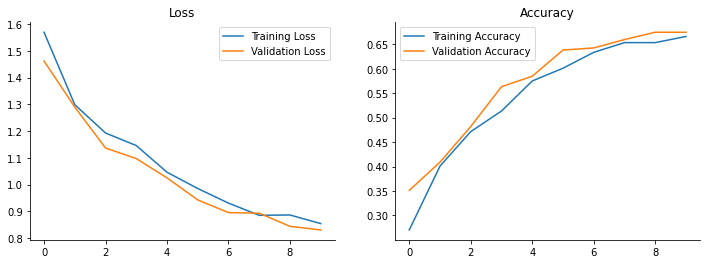

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

**Testing**

In [21]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    x_col = "img_path",
    y_col = "label",
    class_mode = "categorical",
    target_size = (227, 227),
    batch_size = BATCH_SIZE,
    seed = 666,
    shuffle = False
)

Found 432 validated image filenames belonging to 5 classes.


In [ ]:
test_pred = model.predict(test_generator, steps = np.ceil(test_data.shape[0] / BATCH_SIZE))
test_data.loc[:, "test_pred"] = np.argmax(test_pred, axis = 1)

labels = dict((v, k) for k, v in test_generator.class_indices.items())

test_data.loc[:, "test_pred"] = test_data.loc[:, "test_pred"].map(labels)

4/4 [==============================] - 92s 29s/step
